In [2]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 993kB 2.8MB/s 


In [0]:
import pandas as pd
link_hilstrom = 'https://drive.google.com/open?id=15osyN4c5z1pSo1JkxwL_N8bZTksRvQuU'
fluff, id = link_hilstrom.split('=')
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('Hillstrom.csv')
hillstrom_df = pd.read_csv('Hillstrom.csv')

In [0]:
import pandas as pd
link_ = 'https://drive.google.com/open?id=1b8N7WtwIe2WmQJD1KL5UAy70K13MxwKj'
fluff, id = link_.split('=')
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('Lalonde.csv')
lalonde_df = pd.read_csv('Lalonde.csv')

In [0]:
import csv
import json
import os
from os.path import isfile, join
from sklearn.model_selection import KFold, StratifiedKFold


def preprocess_data(df, dataset='hillstrom', verbose=True):
    """
    Preprocessing the dataset
     - Use one-hot encoding for categorical features
     - Check the name of the target variable and treatment variable
     - Drop the unused columns
     - Delete the unused data
    
    Args:
        df: A pandas.DataFrame which have all data of the dataset
        dataset: the name of the dataset
    Return:
        # I recommend to split into the dataframes of predictor variables, the 
        # target variable, and the treatment varaible
        # df_x: the dataframes of predictor variables
        # s_y: target variables
        # s_t: treatment variables
    """
    if dataset in ['hillstrom', 'email']:
        # For Hillstrom dataset, the ‘‘visit’’ target variable was selected
        #   as the target variable of interest and the selected treatment is 
        #   the e-mail campaign for women’s merchandise [1]
        # [1] Kane K, Lo VSY, Zheng J. True-lift modeling: Comparison of methods. 
        #    J Market Anal. 2014;2:218–238
    
        # Delete unused data: men's email cases should be removed
        df_x = df[df.segment != 'Mens E-Mail'].reset_index()
        # Assign Y for target (visit: 0, 1)
        s_y = df_x['visit']
        # Assign T for treatment (segment: Womens E-Mail, Mens E-Mail (not used), No E-Mail)
        s_t = (df_x['segment'] == 'Womens E-Mail').astype('int64')
        # Drop unused columns from X
        df_x = df_x.drop(columns=['conversion', 'spend', 'visit', 'segment', 'index'])
        # One-hot encoding for categorical features
        df_x = pd.get_dummies(df_x)

    elif dataset in ['criteo', 'ad']:
        raise NotImplementedError

    elif dataset in ['lalonde', 'job']:
        # Delete unused data: None
        df_x = df.reset_index()
        # Target variables (RE78: earnings in 1978)
        s_y = df_x['RE78']
        # Treatment variables (treatment: 0, 1)
        s_t = df_x['treatment']
        # Drop unused columns
        df_x = df_x.drop(columns=['treatment', 'RE78', 'index'])
        # One-hot encoding for categorical features
        df_x = pd.get_dummies(df_x)

    else:
        raise NotImplementedError

    return df_x, s_y, s_t

In [7]:
def print_preproccessing_data(df_x, s_y, s_t):
    print(df_x[:5])
    print(df_x.columns.values)
    print(df_x.shape)
    print(s_y[:5])
    print(s_t[:5])


hillstrom_df_x, hillstrom_s_y, hillstrom_s_t = preprocess_data(hillstrom_df, 'hillstrom')
print_preproccessing_data(hillstrom_df_x, hillstrom_s_y, hillstrom_s_t)

lalonde_df_x, lalonde_s_y, lalonde_s_t = preprocess_data(lalonde_df, 'lalonde')
print_preproccessing_data(lalonde_df_x, lalonde_s_y, lalonde_s_t)

"""
def print_preproccessing_data(df):
    print(df[:5])
    print(df.columns.values)
    print(df.shape)
    print(df['Y'][:5])
    print(df['T'][:5])


hillstrom_df_pre = preprocess_data(hillstrom_df, 'hillstrom')
print_preproccessing_data(hillstrom_df_pre)

lalonde_df_pre = preprocess_data(lalonde_df, 'lalonde')
print_preproccessing_data(lalonde_df_pre)
"""

   recency  history  mens  ...  channel_Multichannel  channel_Phone  channel_Web
0       10   142.44     1  ...                     0              1            0
1        6   329.08     1  ...                     0              0            1
2        7   180.65     0  ...                     0              0            1
3        2    45.34     1  ...                     0              0            1
4        6   134.83     0  ...                     0              1            0

[5 rows x 18 columns]
['recency' 'history' 'mens' 'womens' 'newbie'
 'history_segment_1) $0 - $100' 'history_segment_2) $100 - $200'
 'history_segment_3) $200 - $350' 'history_segment_4) $350 - $500'
 'history_segment_5) $500 - $750' 'history_segment_6) $750 - $1,000'
 'history_segment_7) $1,000 +' 'zip_code_Rural' 'zip_code_Surburban'
 'zip_code_Urban' 'channel_Multichannel' 'channel_Phone' 'channel_Web']
(42693, 18)
0    0
1    0
2    0
3    0
4    1
Name: visit, dtype: int64
0    1
1    0
2    1
3    1
4 

"\ndef print_preproccessing_data(df):\n    print(df[:5])\n    print(df.columns.values)\n    print(df.shape)\n    print(df['Y'][:5])\n    print(df['T'][:5])\n\n\nhillstrom_df_pre = preprocess_data(hillstrom_df, 'hillstrom')\nprint_preproccessing_data(hillstrom_df_pre)\n\nlalonde_df_pre = preprocess_data(lalonde_df, 'lalonde')\nprint_preproccessing_data(lalonde_df_pre)\n"

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

def performance(pr_y1_t1, pr_y1_t0, y, ct, groups=10):
    """
    1. Split the total customers into the given number of groups
    2. Calculate the statistics of each segment
    
    Args:
        pr_y1_ct1: the series (list) of the customer's expected return
        pr_y1_ct0: the expected return when a customer is not treated
        y: the observed return of customers
        ct: whether each customer is treated or not
        groups: the number of groups (segments). Should be 5, 10, or 20
    Return:
        DataFrame:
            columns:
                'n_y1_ct1': the number of treated responders
                'n_y1_ct0': the number of not treated responders
                'r_y1_ct1': the average return of treated customers
                'r_y1_ct0': the average return of not treated customers
                'n_ct1': the number of treated customers
                'n_ct0': the number of not treated customers
                'uplift': the average uplift (the average treatment effect)
            rows: the index of groups
    """

    ### check valid arguments
    if groups not in [5, 10, 20]:
        raise Exception("uplift: groups must be either 5, 10 or 20")

    ### check for NAs.
    if pr_y1_t1.isnull().values.any():
        raise Exception("uplift: NA not permitted in pr_y1_ct1")
    if pr_y1_t0.isnull().values.any():
        raise Exception("uplift: NA not permitted in pr_y1_ct0")
    if y.isnull().values.any():
        raise Exception("uplift: NA not permitted in y")
    if ct.isnull().values.any():
        raise Exception("uplift: NA not permitted in ct")

    ### check valid values for ct
    if set(ct) != {0, 1}:
        raise Exception("uplift: ct must be either 0 or 1")

    ### check length of arguments
    if not (len(pr_y1_t1) == len(pr_y1_t0) == len(y) == len(ct)):
        raise Exception("uplift: arguments pr_y1_ct1, pr_y1_ct0, y and ct must all have the same length")

    ###############################
    ###     Do it yourself!     ###
    ###############################
    # tr: treated responder, cr: controlled responder
    # Customers ordered by predicted uplift values in descending order are segmented.
    df = pd.DataFrame(data={'ct': ct, 'y': y,
                            'uplift_rank': (pr_y1_t1 - pr_y1_t0).rank(ascending=False, method='first')})
    df_group = df.groupby(pd.qcut(df['uplift_rank'], groups, labels=range(1, groups + 1)).rename('groups'))
    
    # Get group data
    n_ct1 = df_group['ct'].sum()
    n_ct0 = df_group.size() - n_ct1
    n_y1_t1 = df_group.apply(lambda r: r[r['ct'] == 1]['y'].sum())
    n_y1_t0 = df_group.apply(lambda r: r[r['ct'] == 0]['y'].sum())
    r_y1_t1 = n_y1_t1 / n_ct1
    r_y1_t0 = n_y1_t0 / n_ct0
    uplift = r_y1_t1 - r_y1_t0
    
    return pd.DataFrame(data={'n_y1_t1': n_y1_t1, 'n_y1_t0': n_y1_t0,
                              'r_y1_t1': r_y1_t1, 'r_y1_t0': r_y1_t0,
                              'n_t1': n_ct1, 'n_t0': n_ct0, 'uplift': uplift})


def qini(perf, plotit=True):
    nrow = len(perf)

    # Calculating the incremental gains. 
    # - First, the cumulitative sum of the treated and the control groups are
    #  calculated with respect to the total population in each group at the
    #  specified decile
    # - Afterwards we calculate the percentage of the total amount of people
    #  (both treatment and control) are present in each decile
    cumul_y1_t1 = (perf['n_y1_t1'].cumsum() / perf['n_t1'].cumsum()).fillna(0)
    cumul_y1_t0 = (perf['n_y1_t0'].cumsum() / perf['n_t0'].cumsum()).fillna(0)
    deciles = [i/nrow for i in range(1, nrow+1)]

    ### Model Incremental gains
    inc_gains = (cumul_y1_t1 - cumul_y1_t0) * deciles
    inc_gains = [0.0] + list(inc_gains)

    ### Overall incremental gains
    overall_inc_gain = sum(perf['n_y1_t1']) / sum(perf['n_t1']) \
            - sum(perf['n_y1_t0']) / sum(perf['n_t0'])

    ### Random incremental gains
    random_inc_gains = [i*overall_inc_gain / nrow for i in range(nrow+1)]

    ### Compute area under the model incremental gains (uplift) curve
    x = [0] + deciles
    y = list(inc_gains)
    auuc = 0
    auuc_rand = 0

    auuc_list = [auuc]
    for i in range(1, len(x)):
        auuc += 0.5 * (x[i] - x[i-1]) * (y[i] + y[i-1])
        auuc_list.append(auuc)

    ### Compute area under the random incremental gains curve
    y_rand = random_inc_gains

    auuc_rand_list = [auuc_rand]
    for i in range(1, len(x)):
        auuc_rand += 0.5 * (x[i] - x[i-1]) * (y_rand[i] + y_rand[i-1])
        auuc_rand_list.append(auuc_rand)

    ### Compute the difference between the areas (Qini coefficient)
    Qini = auuc - auuc_rand

    ### Plot incremental gains curve
    if plotit:
        x_axis = x
        plt.plot(x_axis, inc_gains)
        plt.plot(x_axis, random_inc_gains)
        plt.show()
    
    ### Qini 30%, Qini 10%
    n_30p = int(nrow*3/10)
    n_10p = int(nrow/10)
    qini_30p = auuc_list[n_30p] - auuc_rand_list[n_30p]
    qini_10p = auuc_list[n_10p] - auuc_rand_list[n_10p]

    res = {
        'qini': Qini,
        'inc_gains': inc_gains,
        'random_inc_gains': random_inc_gains,
        'auuc_list': auuc_list,
        'auuc_rand_list': auuc_rand_list,
        'qini_30p': qini_30p,
        'qini_10p': qini_10p,
    }    

    return res


def qini2(perf, plotit=True):
    """
    Calculating the incremental gains (y-axis of Qini curve)
     - First, the cumulitative sum of the treated and the control groups are
      calculated with respect to the total population in each group at the
      specified decile
     - Afterwards we calculate the percentage of the total amount of people
      (both treatment and control) are present in each decile
    Args:
        perf: A return of the performance function (above)
        plotit: whether draw a plot or not
    Return:
        1. Qini value
        2. return or save the plot if plotit is True
    """
    
    ###############################
    ###     Do it yourself!     ###
    ###############################
    # Get qini value
    s_rt = perf['r_y1_ct1'].cumsum() / perf['n_y1_ct1'].cumsum()
    s_rc = perf['r_y1_ct0'].cumsum() / perf['n_y1_ct0'].cumsum()
    k = len(s_rt)
    qini_value = s_rt * s_rt.index / k

    # Draw qini curve
    plt.rcParams['figure.figsize'] = (5.0, 4.0)
    plt.plot(qini_value, label='qini')
    plt.legend(['Bad model'])
    plt.show()
    
    return qini_value


In [10]:
import itertools
import numpy as np

def parameter_tuning(fit_mdl, pred_mdl, data, search_space):
    """
    Given a model, search all combination of parameter sets and find
    the best parameter set
    
    Args:
        fit_mdl: model function
        pred_mdl: predict function of fit_mdl
        data:
            {
                "x_train": predictor variables of training dataset,
                "y_train": target variables of training dataset,
                "ct_train": treatment variables of training dataset,
                "x_test": predictor variables of test (usually, validation) dataset,
                "y_test": target variables of test (usually, validation) dataset,
                "ct_test": treatment variables of test (usually, validation) dataset,
            }
        search_space:
            {
                parameter_name: [search values]
            }
    Return:
        The best parameter set
    """
    
    ###############################
    ###     Do it yourself!     ###
    ###############################
    return ##

  
def wrapper(fit_mdl, pred_mdl, data)
    """
    General wrapper approach
    
    Args:
        fit_mdl: model function
        pred_mdl: predict function of fit_mdl
        data:
            {
                "x_train": predictor variables of training dataset,
                "y_train": target variables of training dataset,
                "ct_train": treatment variables of training dataset,
                "x_test": predictor variables of test (usually, validation) dataset,
                "y_test": target variables of test (usually, validation) dataset,
                "ct_test": treatment variables of test (usually, validation) dataset,
            }
    Return:
        (A list of best models, The list of dropped variables)
    """
    
    ###############################
    ###     Do it yourself!     ###
    ###############################
    return ##


SyntaxError: ignored

In [0]:
import itertools
import numpy as np

def parameter_tuning(fit_mdl, pred_mdl, data, search_space):
    """
    Given a model, search all combination of parameter sets and find
    the best parameter set
    
    Args:
        fit_mdl: model function
        pred_mdl: predict function of fit_mdl
        data:
            {
                "x_train": predictor variables of training dataset,
                "y_train": target variables of training dataset,
                "t_train": treatment variables of training dataset,
                "x_test": predictor variables of test (usually, validation) dataset,
                "y_test": target variables of test (usually, validation) dataset,
                "t_test": treatment variables of test (usually, validation) dataset,
            }
        search_space:
            {
                parameter_name: [search values]
            }
    Return:
        The best parameter set
    """
    x_train = data['x_train']
    y_train = data['y_train']
    t_train = data['t_train']
    x_test = data['x_test']
    y_test = data['y_test']
    t_test = data['t_test']
    
    max_q = -float('inf')
    best_mdl = None

    keys = search_space.keys()
    n_space = [len(search_space[key]) for key in keys]
    n_iter = np.prod(n_space)
    
    best_params = None
    for i in range(n_iter):
        params = {}
        for idx, key in enumerate(keys):
            params[key] = search_space[key][i % n_space[idx]]
            i = int(i / n_space[idx])

        mdl = fit_mdl(x_train, y_train, t_train, **params)
        pred = pred_mdl(mdl, newdata=x_test, y=y_test, ct=t_test)
        # print('    {}'.format(params))
        try:
            perf = performance(pred['pr_y1_t1'], pred['pr_y1_t0'], y_test, t_test)
        except Exception as e:
            print(e)
            continue
        q = qini(perf, plotit=False)['qini']
        if q > max_q:
            max_q = q
            best_mdl = mdl
            best_params = params

    return best_mdl, best_params


def wrapper(fit_mdl, pred_mdl, data, params=None,
            best_models=None, drop_variables=None, qini_values=None):
    """
    General wrapper approach
    
    Args:
        fit_mdl: model function
        pred_mdl: predict function of fit_mdl
        data:
            {
                "x_train": predictor variables of training dataset,
                "y_train": target variables of training dataset,
                "t_train": treatment variables of training dataset,
                "x_test": predictor variables of test (usually, validation) dataset,
                "y_test": target variables of test (usually, validation) dataset,
                "t_test": treatment variables of test (usually, validation) dataset,
            }
    Return:
        (A list of best models, The list of dropped variables)
    """
    if best_models is None:
        best_models = []
    if drop_variables is None:
        drop_variables = []
    if qini_values is None:
        qini_values = []
    if params is None:
        params = {}

    x_train = data['x_train']
    y_train = data['y_train']
    t_train = data['t_train']
    x_test = data['x_test']
    y_test = data['y_test']
    t_test = data['t_test']

    variables = data['x_train'].columns

    max_q = -float('inf')
    drop_var = None
    best_mdl = None
    for var in variables:
        if var in drop_variables:
            continue
        x = x_train.copy()
        x.drop(drop_variables + [var], axis=1, inplace=True)
        mdl = fit_mdl(x, y_train, t_train, **params)
        x = x_test.copy()
        x.drop(drop_variables + [var], axis=1, inplace=True)
        pred = pred_mdl(mdl, newdata=x, y=y_test, ct=t_test)
        perf = performance(pred['pr_y1_t1'], pred['pr_y1_t0'], y_test, t_test)
        q = qini(perf, plotit=False)['qini']
        if q > max_q:
            max_q = q
            drop_var = var
            best_mdl = mdl
    
    best_models.append(best_mdl)
    drop_variables.append(drop_var)
    qini_values.append(max_q)

    left_vars = [var for var in variables if (var not in drop_variables)]
    
    if len(variables) == len(drop_variables) + 1:
        return best_models, drop_variables + left_vars, qini_values
    else:
        return wrapper(fit_mdl, pred_mdl, data, params=params,
                       best_models=best_models, drop_variables=drop_variables,
                       qini_values=qini_values)

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression


def tma(x, y, ct, method=LogisticRegression, **kwargs):
    """Training a model according to the "Two Model Approach" 
    (a.k.a. "Separate Model Approach")
    The default model is General Linear Model (GLM)
    
    Source: "Incremental Value Modeling" (Hansotia, 2002)

    Args:
        x: A data frame of predictors.
        y: A binary response (numeric) vector.
        ct: A binary response (numeric) representing the treatment assignment
            (coded as 0/1).
        method: A sklearn model specifying which classification or regression
            model to use. This should be a method that can handle a 
            multinominal class variable.

    Return:
        Dictionary: A dictionary of two models. One for the treatment group, 
            one for the control group.

            {
                'model_treat': a model for the treatment group,
                'model_control': a model for the control group
            }

    """
    
    ###############################
    ###     Do it yourself!     ###
    ###############################
    return {
        'model_treat': method(**kwargs).fit(x[ct == 1], y[ct == 1]),
        'model_control': method(**kwargs).fit(x[ct == 0], y[ct == 0])
    }


def predict_tma(obj, newdata, **kwargs):
    """Predictions according to the "Two Model Approach" 
    (a.k.a. "Separate Model Approach")
    
    For each instance in newdata two predictions are made:
    1) What is the probability of a person responding when treated?
    2) What is the probability of a person responding when not treated
      (i.e. part of control group)?

    Source: "Incremental Value Modeling" (Hansotia, 2002)

    Args:
        obj: A dictionary of two models. 
            One for the treatment group, one for the control group.
        newdata: A data frame containing the values at which predictions
            are required.
    
    Return:
        DataFrame: A dataframe with predicted returns for when the customers
            are treated and for when they are not treated.
            'pr_y1_ct1': when treated, 'pr_y1_ct0': when not treated
    """

    ###############################
    ###     Do it yourself!     ###
    ###############################
    # LogisticRegression: use predict_proba and return result[:, 1] for True class
    # LinearRegression: use predict
    if isinstance(obj['model_treat'], LogisticRegression):
        return pd.DataFrame(data={
            'pr_y1_t1': obj['model_treat'].predict_proba(newdata)[:, 1],
            'pr_y1_t0': obj['model_control'].predict_proba(newdata)[: , 1]
        })
    else:
        return pd.DataFrame(data={
            'pr_y1_t1': obj['model_treat'].predict(newdata),
            'pr_y1_t0': obj['model_control'].predict(newdata)
        })

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


        n_y1_t1  n_y1_t0   r_y1_t1   r_y1_t0  n_t1  n_t0    uplift
groups                                                            
1            93       52  0.212329  0.125000   438   416  0.087329
2            84       39  0.202410  0.088838   415   439  0.113571
3            89       42  0.206977  0.099057   430   424  0.107920
4            86       40  0.187773  0.101010   458   396  0.086763
5            62       34  0.146919  0.078704   422   432  0.068216


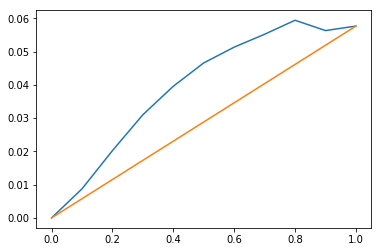

{'qini': 0.010886993893016478, 'inc_gains': [0.0, 0.008732876712328766, 0.020214036458868937, 0.031001726431588397, 0.03955962862311076, 0.046578441717621794, 0.051316075847424814, 0.05518711518027393, 0.05940017746228926, 0.05629658572504883, 0.05764816116186461], 'random_inc_gains': [0.0, 0.0057648161161864605, 0.011529632232372921, 0.017294448348559383, 0.023059264464745842, 0.028824080580932304, 0.034588896697118766, 0.04035371281330523, 0.046118528929491684, 0.05188334504567815, 0.05764816116186461], 'auuc_list': [0, 0.0004366438356164383, 0.0018839894941763235, 0.0044447776386991895, 0.007972845391434148, 0.012279748908470774, 0.017174474786723105, 0.022499634338108043, 0.02822899897023621, 0.03401383712960311, 0.03971107447394878], 'auuc_rand_list': [0, 0.000288240805809323, 0.001152963223237292, 0.002594167252283907, 0.004611852892949169, 0.007206020145233076, 0.010376669009135628, 0.014123799484656828, 0.018447411571796676, 0.023347505270555166, 0.028824080580932304], 'qini_30

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


        n_y1_t1  n_y1_t0   r_y1_t1   r_y1_t0  n_t1  n_t0    uplift
groups                                                            
1            72       65  0.176471  0.145740   408   446  0.030731
2            84       50  0.202410  0.113895   415   439  0.088514
3            76       38  0.169643  0.093596   448   406  0.076047
4            72       49  0.165138  0.117225   436   418  0.047913
5            69       38  0.157175  0.091566   439   415  0.065609


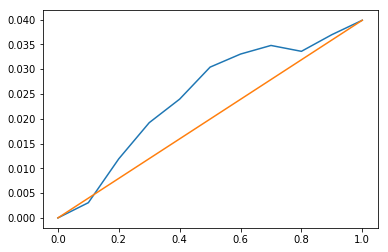

{'qini': 0.004755448633548938, 'inc_gains': [0.0, 0.0030730677921392783, 0.011921384489706255, 0.01920619723425689, 0.023956976110827168, 0.030408696247387075, 0.03304208387508822, 0.03477923828783282, 0.03359402263804086, 0.03695135274866236, 0.03986189624187812], 'random_inc_gains': [0.0, 0.003986189624187812, 0.007972379248375624, 0.011958568872563437, 0.015944758496751248, 0.01993094812093906, 0.023917137745126875, 0.027903327369314685, 0.031889516993502495, 0.03587570661769031, 0.03986189624187812], 'auuc_list': [0, 0.00015365338960696392, 0.0009033760036992406, 0.0024597550898973974, 0.004617913757151601, 0.007336197375062313, 0.010508736381186077, 0.013899802489332128, 0.017318465535625816, 0.020845734304960978, 0.024686396754488], 'auuc_rand_list': [0, 0.0001993094812093906, 0.0007972379248375624, 0.001793785330884515, 0.00318895169935025, 0.004982737030234765, 0.007175141323538062, 0.00976616457926014, 0.012755806797401003, 0.01614406797796064, 0.01993094812093906], 'qini_30p'

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


        n_y1_t1  n_y1_t0   r_y1_t1   r_y1_t0  n_t1  n_t0    uplift
groups                                                            
1            79       59  0.188995  0.135321   418   436  0.053674
2            78       46  0.175281  0.112469   445   409  0.062811
3            70       46  0.165094  0.106977   424   430  0.058118
4            77       44  0.185542  0.100228   415   439  0.085314
5            74       42  0.176190  0.096774   420   434  0.079416


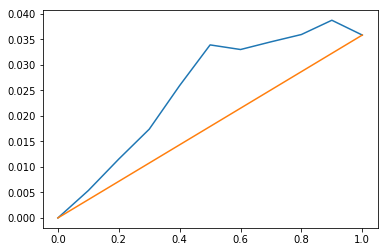

{'qini': 0.0075060438428973045, 'inc_gains': [0.0, 0.0053674114393573585, 0.01153263351320219, 0.01738434114904703, 0.025937773804447242, 0.03389932023652189, 0.03299428373906197, 0.034502859346488834, 0.0359342585205338, 0.03872969906417786, 0.03582714275197002], 'random_inc_gains': [0.0, 0.003582714275197002, 0.007165428550394004, 0.010748142825591006, 0.014330857100788009, 0.01791357137598501, 0.02149628565118201, 0.025078999926379013, 0.028661714201576018, 0.032244428476773015, 0.03582714275197002], 'auuc_list': [0, 0.00026837057196786796, 0.0011133728195958455, 0.002559221552708306, 0.00472532730038302, 0.007717182002431476, 0.011061862201210668, 0.014436719355488207, 0.017958575248839342, 0.021691773128074923, 0.025419615218882315], 'auuc_rand_list': [0, 0.00017913571375985013, 0.0007165428550394005, 0.0016122214238386509, 0.002866171420157602, 0.0044783928439962525, 0.0064488856953546034, 0.008777649974232655, 0.011464685680630408, 0.014509992814547859, 0.01791357137598501], 'qi

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


        n_y1_t1  n_y1_t0   r_y1_t1   r_y1_t0  n_t1  n_t0    uplift
groups                                                            
1            87       52  0.197727  0.125604   440   414  0.072123
2            82       41  0.190255  0.096927   431   423  0.093329
3            81       54  0.194245  0.123570   417   437  0.070675
4            71       38  0.164733  0.090047   431   422  0.074686
5            85       30  0.187225  0.075000   454   400  0.112225


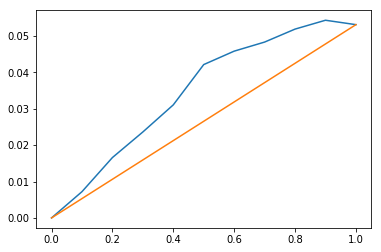

{'qini': 0.008197605806603406, 'inc_gains': [0.0, 0.00721234079929732, 0.016583747927031513, 0.02361442904921166, 0.031062514406137838, 0.042131068140221946, 0.04582066785847209, 0.04831510650164854, 0.051876997713051, 0.05431195951966776, 0.053100616410823476], 'random_inc_gains': [0.0, 0.005310061641082347, 0.010620123282164695, 0.01593018492324704, 0.02124024656432939, 0.026550308205411738, 0.03186036984649408, 0.037170431487576434, 0.04248049312865878, 0.04779055476974113, 0.053100616410823476], 'auuc_list': [0, 0.00036061703996486603, 0.0015504214762813078, 0.0035603303250934656, 0.0062941774978609415, 0.00995385662517893, 0.01435144342511363, 0.01905823214311966, 0.02406783735385464, 0.02937728521549058, 0.034747914012015144], 'auuc_rand_list': [0, 0.0002655030820541174, 0.0010620123282164696, 0.002389527738487056, 0.004248049312865878, 0.006637577051352934, 0.009558110953948224, 0.01300965102065175, 0.016992197251463514, 0.021505749646383507, 0.026550308205411738], 'qini_30p': 0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


        n_y1_t1  n_y1_t0   r_y1_t1   r_y1_t0  n_t1  n_t0    uplift
groups                                                            
1            97       64  0.245570  0.139434   395   459  0.106136
2            57       43  0.138015  0.097506   413   441  0.040509
3            80       50  0.186480  0.117647   429   425  0.068833
4            71       42  0.168646  0.097222   421   432  0.071424
5            77       28  0.171875  0.068966   448   406  0.102909


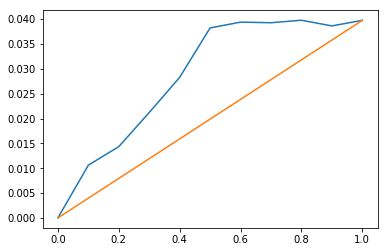

{'qini': 0.00908416086497734, 'inc_gains': [0.0, 0.010613606905490748, 0.014341034103410342, 0.02120303229053858, 0.028278133373794152, 0.038219840808837564, 0.0393881260220052, 0.039266006195946807, 0.03976811594202898, 0.038628169778472485, 0.03974765706016699], 'random_inc_gains': [0.0, 0.003974765706016699, 0.007949531412033398, 0.011924297118050096, 0.015899062824066796, 0.019873828530083494, 0.023848594236100192, 0.027823359942116894, 0.03179812564813359, 0.03577289135415029, 0.03974765706016699], 'auuc_list': [0, 0.0005306803452745374, 0.001778412395719592, 0.0035556157154170375, 0.006029673998633675, 0.00935457270776526, 0.013234971049307397, 0.017167677660204994, 0.02111938376710379, 0.02503919805312886, 0.028957989395060835], 'auuc_rand_list': [0, 0.00019873828530083497, 0.00079495314120334, 0.0017886445677075145, 0.0031798125648133595, 0.0049684571325208735, 0.007154578270830057, 0.009738175979740912, 0.01271925025925344, 0.01609780110936763, 0.019873828530083494], 'qini_30p

In [204]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split

def main():
    ### Hyper parameters ###
    dataset = 'hillstrom'
    seed = 1234
    n_fold = 5
    models = {
        'tma': {'model': tma, 'predict': predict_tma}
    }
    search_space = {
        'method': [LogisticRegression],
        'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
        'penalty': ['none', 'l2'],
        'tol': [1e-2, 1e-3, 1e-4],
        'C': [1e6, 1e3, 1, 1e-3, 1e-6]
    }

    ### Load data & K fold validation ###
    if dataset == 'hillstrom':
        df_x, s_y, s_t = preprocess_data(hillstrom_df, dataset)
        fold_split = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed).split(df_x, s_y)
    elif dataset == 'lalonde':
        df_x, s_y, s_t = preprocess_data(lalonde_df, dataset)
        fold_split = KFold(n_splits=n_fold, shuffle=True, random_state=seed).split(df_x)
    else:
        assert()

    for model_name in models:
        qinis = []
        
        for train_index, test_index in fold_split:
            x_train = df_x.reindex(train_index).reset_index(drop=True)
            y_train = s_y.reindex(train_index).reset_index(drop=True)
            t_train = s_t.reindex(train_index).reset_index(drop=True)
            
            x_test = df_x.reindex(test_index).reset_index(drop=True)
            t_test = s_t.reindex(test_index).reset_index(drop=True)
            y_test = s_y.reindex(test_index).reset_index(drop=True)
            """
            df_train = x_train
            df_train['Y'] = y_train
            df_train['T'] = t_train
            
            df_test = x_test
            df_test['Y'] = y_test
            df_test['T'] = t_test
            
            stratify = pd.DataFrame([y_train, t_train]).T
            df_tune, df_val = train_test_split(df_train, test_size=0.33, random_state=1234, stratify=stratify)

            data_dict = {
                "x_train": df_tune.drop(columns=['Y', 'T']).reset_index(drop=True),
                "y_train": df_tune['Y'].reset_index(drop=True),
                "t_train": df_tune['T'].reset_index(drop=True),
                "x_test": df_val.drop(columns=['Y', 'T']).reset_index(drop=True),
                "y_test": df_val['Y'].reset_index(drop=True),
                "t_test": df_val['T'].reset_index(drop=True),
            }

            model_method = search_space.get('method', None)
            params = {
                'method': None if model_method is None else model_method[0],
            }
            if params['method'] == LogisticRegression:
                solver = search_space.get('solver', None)
                params['solver'] = None if solver is None else solver[0]

            _, drop_vars, qini_values = wrapper(tma, predict_tma, data_dict, params=params)
            
            best_qini = max(qini_values)
            best_idx = qini_values.index(best_qini)
            best_drop_vars = drop_vars[:best_idx]

            #x_tune.drop(best_drop_vars, axis=1, inplace=True)
            #x_val.drop(best_drop_vars, axis=1, inplace=True)
            #x_train.drop(best_drop_vars, axis=1, inplace=True)
            #x_test.drop(best_drop_vars, axis=1, inplace=True)

            _, best_params = parameter_tuning(tma, predict_tma, data_dict, search_space=search_space)           
            """

            model = models[model_name]['model'](x_train, y_train, t_train)
            pred = models[model_name]['predict'](model, x_test)
            # print(pred[: 5])
            
            perf = performance(pred['pr_y1_t1'], pred['pr_y1_t0'], y_test, t_test)
            print(perf[:5])
            
            q = qini(perf)
            print(q)
            qinis.append(q['qini'])

            
        ### Variable selection (General wrapper approach) ###

        ### Parameter tuning ###
        print("Model: {}\n".format(model_name))
        # print("Tuning space: \n")
        # for key, val in search_space.items():
        #    print("    '{}': {}\n".format(key, val))
        print("Seed: {}\n".format(seed))
        print('Qini values: ', qinis)
        print("Qini value: mean = {}, std = {}\n\n".format(np.mean(qinis), np.std(qinis)))
        
main()
